<a href="https://colab.research.google.com/github/DerekLiu35/CTCF-Deep-Learning/blob/main/ctcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CTCF/' # path to folder
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1MAVkvRFDg62-zDZW-7vMwqzi30XDMntc/CTCF


In [ ]:
# !gunzip ENCFF559TGJ.bed.gz

In [11]:
# !wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
# !gunzip hg38.fa.gz

--2024-06-12 01:23:45--  http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938.09M  58.0MB/s    in 21s     

2024-06-12 01:24:07 (43.8 MB/s) - ‘hg38.fa.gz’ saved [983659424/983659424]



In [4]:
!pip install -q pyfaidx bioframe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 5.1 MB/s eta 0:00:00


In [5]:
import pyfaidx
import bioframe
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


In [6]:
ctcf_sites = pd.read_csv('ENCFF559TGJ.bed', sep='\t', header=None)
ctcf_sites.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak']


In [8]:
ctcf_sites

,chrom,start,end,name,score,strand,signalValue,pValue,qValue,peak
0,chr7,158796754,158796918,.,540,.,6.10282,-1.0,0.16762,82
1,chr14,101404554,101404718,.,622,.,7.04923,-1.0,0.36231,82
2,chr20,34311666,34311830,.,541,.,7.39036,-1.0,0.40654,82
3,chr14,52950818,52950982,.,538,.,7.91785,-1.0,0.54603,82
4,chr2,6865481,6865645,.,539,.,8.34686,-1.0,0.62516,82
...,...,...,...,...,...,...,...,...,...,...
35883,chr11,47355351,47355465,.,1000,.,181.44512,-1.0,4.76032,45
35884,chr17,80575450,80575599,.,1000,.,182.40259,-1.0,4.76032,63
35885,chr16,57649149,57649279,.,1000,.,187.15736,-1.0,4.76032,61
35886,chr12,54379786,54379882,.,1000,.,188.26604,-1.0,4.76032,34


In [9]:
def create_regions(assembly: str = "hg38", width: int = 1000, chrom_limit: int = -1):
    """Generate a DataFrame of genomic regions."""
    chromosome_sizes = bioframe.fetch_chromsizes(assembly)[:chrom_limit]
    # Bin the chromosome sizes into intervals of the specified width
    regions = bioframe.binnify(chromosome_sizes, width)
    # Ensure we only include bins that are exactly `width` wide,
    # which also implicitly removes bins too close to the chromosome end
    regions = regions[regions["end"] - regions["start"] == width]
    return regions

bins = create_regions()

In [10]:
positives = ctcf_sites[['chrom', 'start', 'end']]
def adjust_bin(row):
    center = (row['start'] + row['end']) // 2
    return pd.Series({'chrom': row['chrom'], 'start': center - 500, 'end': center + 500})

positives = positives.apply(adjust_bin, axis=1)
positives



,chrom,start,end
0,chr7,158796336,158797336
1,chr14,101404136,101405136
2,chr20,34311248,34312248
3,chr14,52950400,52951400
4,chr2,6865063,6866063
...,...,...,...
35883,chr11,47354908,47355908
35884,chr17,80575024,80576024
35885,chr16,57648714,57649714
35886,chr12,54379334,54380334


In [31]:
# Find bins that do not overlap with CTCF sites (negatives)
non_overlapping_bins = bins[~bins.index.isin(positives.index)]

# Select equal number of negative samples
negatives = non_overlapping_bins.sample(n=len(positives))


In [12]:
from pyfaidx import Fasta

genome = Fasta('hg38.fa')
# genome = Fasta('hg38.fa.fai')
genome

Fasta("hg38.fa")

In [13]:
# def get_sequence(chrom, start, end):
#     return genome[chrom][start:end].seq.upper()

# # Extract sequences for positive bins
# positives['sequence'] = positives.apply(lambda x: get_sequence(x['chrom'], x['start'], x['end']), axis=1)

# # Extract sequences for negative bins
# negatives['sequence'] = negatives.apply(lambda x: get_sequence(x['chrom'], x['start'], x['end']), axis=1)


In [33]:
import numpy as np

def one_hot_encode(sequence):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot = np.zeros((len(sequence), 4), dtype=np.float32)
    for i, base in enumerate(sequence):
        if base in mapping:
            one_hot[i, mapping[base]] = 1.0
    return one_hot

def get_sequence(chrom, start, end):
    return genome[chrom][start:end].seq.upper()

# Encode positive samples
positive_sequences = [one_hot_encode(get_sequence(row['chrom'], row['start'], row['end'])) for _, row in positives.iterrows()]

# Encode negative samples
negative_sequences = [one_hot_encode(get_sequence(row['chrom'], row['start'], row['end'])) for _, row in negatives.iterrows()]


## Model and training


In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

class CTCFCNN(nn.Module):
    def __init__(self):
        super(CTCFCNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, 20)
        self.fc1 = nn.Linear(16 * 981, 1)

    def forward(self, x):
        # N x 4 x 1000
        x = F.relu(self.conv1(x)) # N x 16 x 981 (no padding, L = L - k + 1)
        x = x.view(-1, 16 * 981)
        x = torch.sigmoid(self.fc1(x))
        return x

positive_labels = np.ones(len(positive_sequences))
negative_labels = np.zeros(len(negative_sequences))

all_sequences = np.array(positive_sequences + negative_sequences)
all_sequences = np.transpose(all_sequences, (0, 2, 1))
all_labels = np.concatenate((positive_labels, negative_labels))

# inputs = torch.tensor(all_sequences)
# labels = torch.tensor(all_labels).float()

# dataset = TensorDataset(inputs, labels)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

class GenomicDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence), torch.tensor(label).float()

dataset = GenomicDataset(all_sequences, all_labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CTCFCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

print("Training completed.")

100%|██████████| 1795/1795 [00:05<00:00, 299.83it/s]


Epoch 1, Loss: 0.2637781805086435


100%|██████████| 1795/1795 [00:05<00:00, 332.44it/s]


Epoch 2, Loss: 0.17530376658383187


100%|██████████| 1795/1795 [00:07<00:00, 249.99it/s]


Epoch 3, Loss: 0.1394660065090673


100%|██████████| 1795/1795 [00:06<00:00, 281.63it/s]


Epoch 4, Loss: 0.11318412085315394


100%|██████████| 1795/1795 [00:09<00:00, 196.77it/s]


Epoch 5, Loss: 0.0930457567770169


100%|██████████| 1795/1795 [00:06<00:00, 259.99it/s]


Epoch 6, Loss: 0.07531373972529778


100%|██████████| 1795/1795 [00:06<00:00, 289.67it/s]


Epoch 7, Loss: 0.06180272880568063


100%|██████████| 1795/1795 [00:05<00:00, 347.82it/s]


Epoch 8, Loss: 0.04908792982150315


100%|██████████| 1795/1795 [00:05<00:00, 320.66it/s]


Epoch 9, Loss: 0.04038285488570187


100%|██████████| 1795/1795 [00:06<00:00, 284.06it/s]

Epoch 10, Loss: 0.03217085903451433
Training completed.


# Evaluate

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(device)).squeeze()
        all_labels.extend(labels.numpy())
        all_predictions.extend(outputs.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

roc_auc = roc_auc_score(all_labels, all_predictions)
precision, recall, _ = precision_recall_curve(all_labels, all_predictions)
aupr = auc(recall, precision)
accuracy = accuracy_score(all_labels, all_predictions > 0.5)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"AUPR: {aupr:.3f}")
print(f"Accuracy: {accuracy:.3f}")


ROC AUC: 0.972
AUPR: 0.965
Accuracy: 0.904


In [ ]:
Naive ovelapping positives:
ROC AUC: 0.776
AUPR: 0.762
Accuracy: 0.708


centered positives
ROC AUC: 0.972
AUPR: 0.965
Accuracy: 0.904

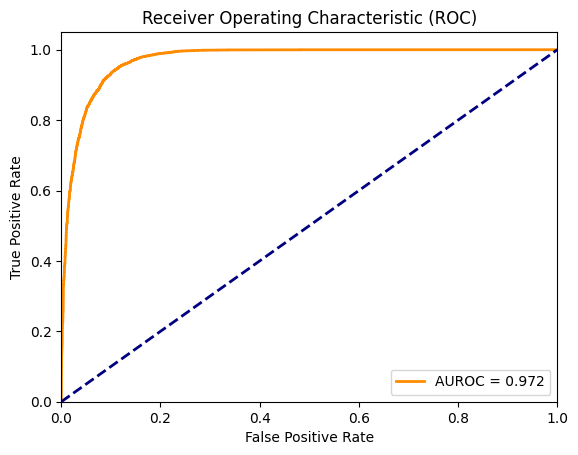

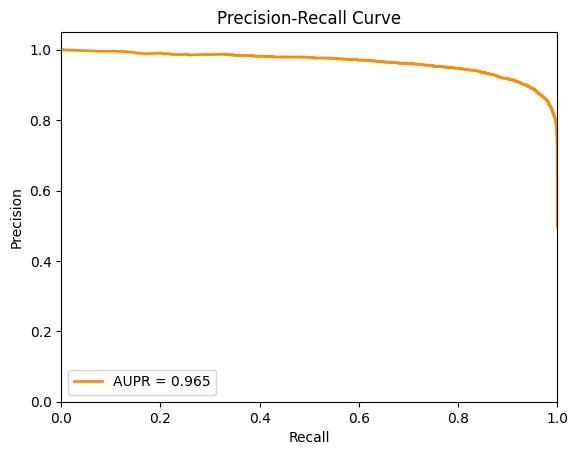

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(all_labels, all_predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(all_labels, all_predictions)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUPR = {aupr:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
